In [1]:
from glob import glob
import numpy as np
import os
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torchtext
import torch
from torchtext.vocab import Vectors

from utils import tokenizer_with_preprocessing
from trainer import Trainer

from IPython.display import HTML

LOG_DIR = os.path.join('.', 'logs')
NEWS_PATH = os.path.join('..', 'data', 'news')

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--max_length', type=int, default=64)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--target_update_freq', type=int, default=100)
parser.add_argument('--evaluation_freq', type=int, default=10)
parser.add_argument('--network_save_freq', type=int, default=10)
parser.add_argument('--num_actions', type=int, default=1)

parser.add_argument('--min_freq', type=int, default=10)
parser.add_argument('--embedding_dim', type=int, default=300)
parser.add_argument('--n_filters', type=int, default=50)
parser.add_argument('--filter_sizes', type=list, default=[3, 4, 5])
parser.add_argument('--pad_idx', type=list, default=1)
parser.add_argument('--gamma', type=float, default=0.0)
parser.add_argument('--learning_rate', type=float, default=2.5e-4)

parser.add_argument('--test', action='store_true')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
parser.add_argument('--device', type=str, default=device)

parser.add_argument('--num_quantile', type=int, default=32)

args = parser.parse_args(args=[])

args.rnn = False

torch.backends.cudnn.benchmark = True

# 読み込んだ内容に対して行う処理を定義
TEXT = torchtext.data.Field(sequential=True, tokenize=tokenizer_with_preprocessing,
                            use_vocab=True, lower=True, include_lengths=True,
                            batch_first=True, fix_length=args.max_length,
                            init_token="<cls>", eos_token="<eos>")
LABEL = torchtext.data.Field(sequential=False, use_vocab=False, dtype=torch.float)

train_ds = torchtext.data.TabularDataset.splits(
    path=NEWS_PATH, train='text_train.tsv',
    format='tsv',
    fields=[('Text1', TEXT), ('Text2', TEXT), ('Label', LABEL)])
train_ds = train_ds[0]

val_ds = torchtext.data.TabularDataset.splits(
    path=NEWS_PATH, train='text_val.tsv',
    format='tsv',
    fields=[('Text1', TEXT), ('Text2', TEXT), ('Label', LABEL)])
val_ds = val_ds[0]

test_ds = torchtext.data.TabularDataset.splits(
    path=NEWS_PATH, train='text_test.tsv',
    format='tsv',
    fields=[('Text1', TEXT), ('Text2', TEXT), ('Label', LABEL)])
test_ds = test_ds[0]

japanese_fasttext_vectors = Vectors(name='../data/news/cc.ja.300.vec')

TEXT.build_vocab(train_ds, vectors=japanese_fasttext_vectors, min_freq=10)
TEXT.vocab.freqs

train_dl = torchtext.data.Iterator(
    train_ds, batch_size=1, train=True, shuffle=False)
val_dl = torchtext.data.Iterator(
    val_ds, batch_size=1, train=True, shuffle=False)
test_dl = torchtext.data.Iterator(
    test_ds, batch_size=1, train=True, shuffle=False)

trainer = Trainer(args, TEXT, train_dl)
trainer.load_model()
trainer.model.eval()

IQN(
  (embedding): Embedding(2638, 300)
  (phi): Linear(in_features=64, out_features=64, bias=True)
  (cnn): CNN(
    (convs): ModuleList(
      (0): Conv2d(1, 50, kernel_size=(3, 300), stride=(1, 1))
      (1): Conv2d(1, 50, kernel_size=(4, 300), stride=(1, 1))
      (2): Conv2d(1, 50, kernel_size=(5, 300), stride=(1, 1))
    )
    (fc0): Linear(in_features=150, out_features=64, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (rnn): RNN(
    (lstm): LSTM(300, 50, batch_first=True, bidirectional=True)
    (attn): Attn(
      (fc): Sequential(
        (0): Linear(in_features=50, out_features=24, bias=True)
        (1): ReLU(inplace=True)
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=24, out_features=1, bias=True)
      )
    )
    (fc0): Linear(in_features=50, out_features=64, bias=True)
  )
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc_q): Linear(in_features=64, o

#  シミュレーション

## 通常

In [3]:
curr_q = []
risk_neutral_q = []
risk_sensitive_q = []
risk_averse_q = []
rewards = []
attns = []
states = []
eta0 = 0
eta1 = 1

for batch in test_dl:
    state = batch.Text1[0].to(device)
    with torch.no_grad():
        risk_neutral, _, attn = trainer.model(state, eta0, eta1, eval=True)
        risk_sensitive, _, _ = trainer.model(state, eta0, 0.1, eval=True)
        risk_averse, _, _ = trainer.model(state, 0.9, eta1, eval=True)

    risk_neutral_q.append(risk_neutral.squeeze(2).cpu().numpy())
    risk_sensitive_q.append(risk_sensitive.squeeze(2).cpu().numpy())
    risk_averse_q.append(risk_averse.squeeze(2).cpu().numpy())
    
    attns.append(attn.squeeze(2).cpu().numpy())
    rewards.append(batch.Label.item())
    states.append(state.cpu().numpy())

risk_neutral_q = np.array(risk_neutral_q)
risk_sensitive_q = np.array(risk_sensitive_q)
risk_averse_q = np.array(risk_averse_q)

attns = np.array(attns)
rewards = np.array(rewards)
states = np.array(states)

In [4]:
risk_neutral_q = np.array(risk_neutral_q).reshape(-1, args.num_quantile)
risk_sensitive_q = np.array(risk_sensitive_q).reshape(-1, args.num_quantile)
risk_averse_q = np.array(risk_averse_q).reshape(-1, args.num_quantile)
attns = np.array(attns).reshape(-1, args.max_length)
states = np.array(states).reshape(-1, args.max_length)

In [5]:
# batch = next(iter(test_dl))
# print(batch.Text1[0].shape)

# states = batch.Text1[0].to(device)
# rewards = batch.Label.cpu().numpy()

# with torch.no_grad():
#     curr_q, _ = trainer.model(states, eta=1)
#     cvar_q, _ = trainer.model(states, eta=0.1)
# curr_q = curr_q.squeeze(2).cpu().numpy()
# cvar_q = cvar_q.squeeze(2).cpu().numpy()

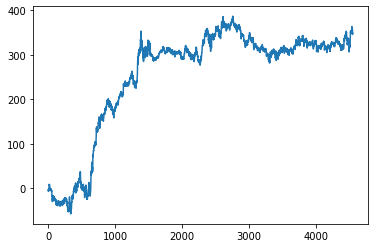

In [6]:
plt.plot(rewards.cumsum())

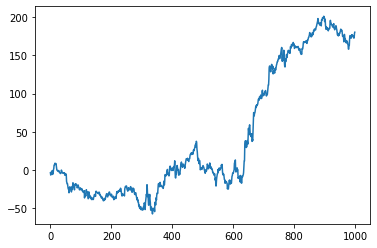

In [7]:
plt.plot(rewards[0:1000].cumsum())

# リスク中立

## 期待値が正の場合のみ

In [8]:
# actions = np.where(np.mean(curr_q, axis=1) > 0, 1, 0)
# epi_rewards = rewards * actions
# print('勝率:', len(epi_rewards[epi_rewards > 0]) 
#                       / len(epi_rewards[epi_rewards != 0]))
# print('利益:', epi_rewards[epi_rewards > 0].sum())
# print('損失:', epi_rewards[epi_rewards < 0].sum())

thred_list = []
mean_list = []
std_list = []
win_list = []
risk_neutral_mean = np.mean(risk_neutral_q, axis=1)

for thred in np.arange(risk_neutral_mean.min(), risk_neutral_mean.max(), 0.1):
    actions = np.where(risk_neutral_mean > thred, 1, 0)
    epi_rewards = (rewards * actions)
    mean = epi_rewards.mean()
    std = epi_rewards.std()
    win_list.append(sum(rewards * actions > 0) / sum(actions > 0))

    thred_list.append(thred)
    mean_list.append(mean)
    std_list.append(std)
    

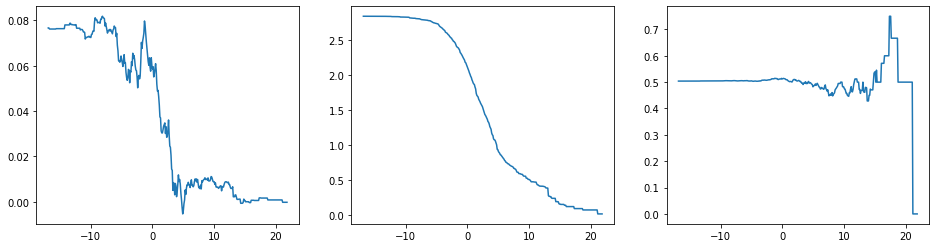

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].plot(thred_list, mean_list)
ax[1].plot(thred_list, std_list)
ax[2].plot(thred_list, win_list)

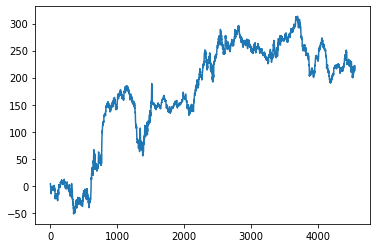

In [10]:
actions = np.where(np.mean(risk_neutral_q, axis=1) > 0.1, 1, 0)
short_actions = np.where(np.mean(risk_neutral_q, axis=1) < -0.1, -1, 0)
epi_rewards = rewards * actions
epi_rewards += rewards * short_actions
plt.plot(epi_rewards.cumsum())

In [11]:
actions[actions > 0].shape

(2297,)

In [12]:
thred_list = []
median_list = []
std_list = []
win_list = []
risk_neutral_median = np.median(risk_neutral_q, axis=1)

for thred in np.arange(risk_neutral_median.min(), risk_neutral_median.max(), 0.1):
    actions = np.where(risk_neutral_median > thred, 1, 0)
    epi_rewards = (rewards * actions)
    median = epi_rewards.mean()
    std = epi_rewards.std()
    win_list.append(sum(rewards * actions > 0) / sum(actions > 0))

    thred_list.append(thred)
    median_list.append(median)
    std_list.append(std)
    

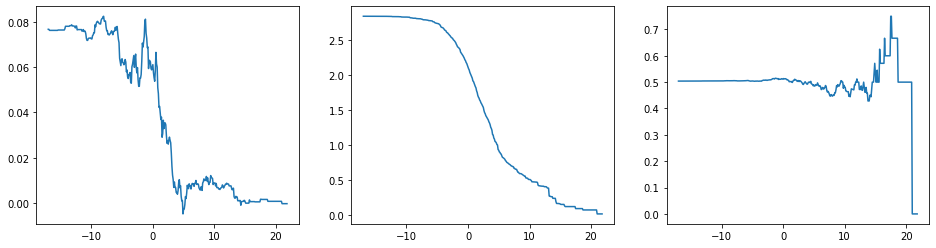

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].plot(thred_list, median_list)
ax[1].plot(thred_list, std_list)
ax[2].plot(thred_list, win_list)

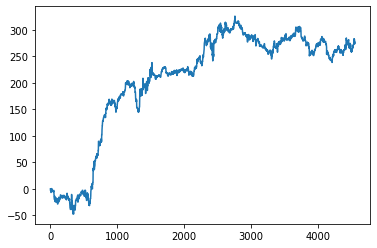

In [14]:
actions = np.where(np.median(risk_neutral_q, axis=1) > 0, 1, 0)
epi_rewards = rewards * actions
plt.plot(epi_rewards.cumsum())

## Sharpe Ratio

In [15]:
thred_list = []
mean_list = []
std_list = []
win_list = []
sr = risk_neutral_q.mean(axis=1) / risk_neutral_q.std(axis=1)

for thred in np.arange(sr.min(), sr.max(), 0.1):
    actions = np.where(sr > thred, 1, 0)
    epi_rewards = (rewards * actions)
    mean = epi_rewards.mean()
    std = epi_rewards.std()
    win_list.append(sum(rewards * actions > 0) / sum(actions > 0))

    thred_list.append(thred)
    mean_list.append(mean)
    std_list.append(std)

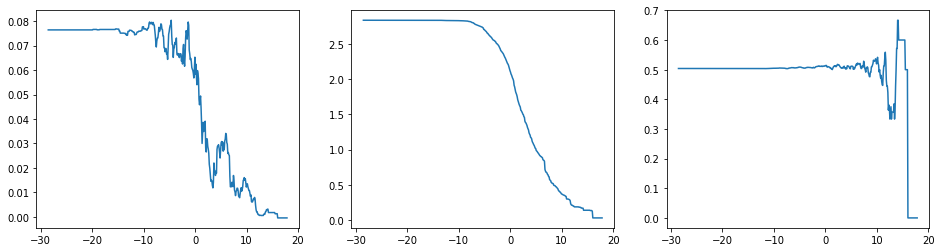

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].plot(thred_list, mean_list)
ax[1].plot(thred_list, std_list)
ax[2].plot(thred_list, win_list)

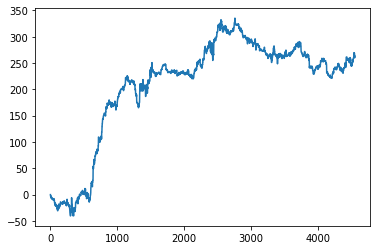

In [17]:
actions = np.where(sr > 0.5, 1, 0)
epi_rewards = rewards * actions
plt.plot(epi_rewards.cumsum())

In [18]:
actions[actions>0].shape

(2060,)

## distの最小値がthred以下の時

In [19]:
thred_list = []
mean_list = []
std_list = []
win_list = []
minv = risk_neutral_q.min(axis=1)

for thred in np.arange(minv.min(), minv.max(), 0.1):
    actions = np.where(minv > thred, 1, 0)
    epi_rewards = (rewards * actions)
    mean = epi_rewards.mean()
    std = epi_rewards.std()
    win_list.append(sum(rewards * actions > 0) / sum(actions > 0))

    thred_list.append(thred)
    mean_list.append(mean)
    std_list.append(std)

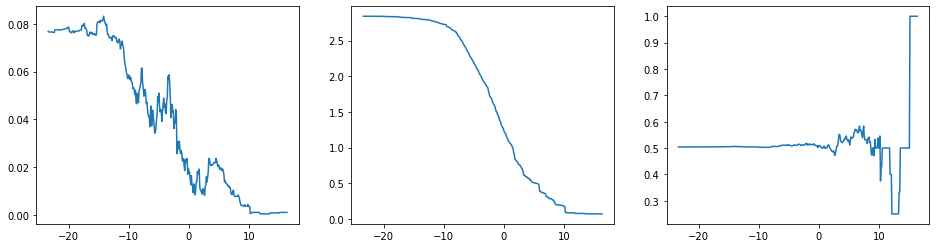

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].plot(thred_list, mean_list)
ax[1].plot(thred_list, std_list)
ax[2].plot(thred_list, win_list)

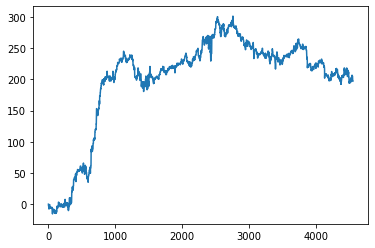

In [21]:
actions = np.where(minv > -3, 1, 0)
epi_rewards = rewards * actions
plt.plot(epi_rewards.cumsum())

# risk_sensitive

## 期待値が正のみ

In [22]:
thred_list = []
mean_list = []
std_list = []
win_list = []
risk_sensitive_mean = np.mean(risk_sensitive_q, axis=1)

for thred in np.arange(risk_sensitive_mean.min(), risk_sensitive_mean.max(), 0.1):
    actions = np.where(risk_sensitive_mean > thred, 1, 0)
    epi_rewards = (rewards * actions)
    mean = epi_rewards.mean()
    std = epi_rewards.std()
    win_list.append(sum(rewards * actions > 0) / sum(actions > 0))

    thred_list.append(thred)
    mean_list.append(mean)
    std_list.append(std)

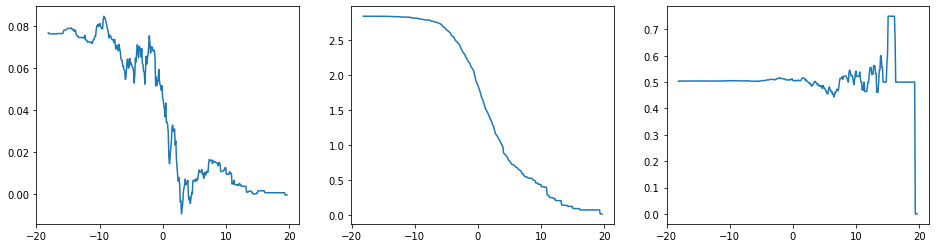

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].plot(thred_list, mean_list)
ax[1].plot(thred_list, std_list)
ax[2].plot(thred_list, win_list)

## Sharpe Ratio

In [24]:
thred_list = []
mean_list = []
std_list = []
win_list = []
sr = risk_sensitive_q.mean(axis=1) / risk_sensitive_q.std(axis=1)

for thred in np.arange(sr.min(), sr.max(), 0.1):
    actions = np.where(sr > thred, 1, 0)
    epi_rewards = (rewards * actions)
    mean = epi_rewards.mean()
    std = epi_rewards.std()
    win_list.append(sum(rewards * actions > 0) / sum(actions > 0))

    thred_list.append(thred)
    mean_list.append(mean)
    std_list.append(std)

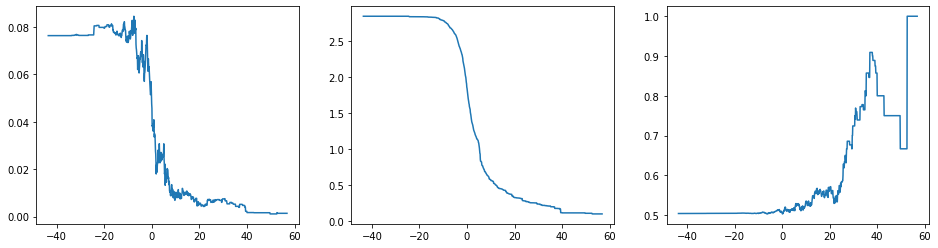

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].plot(thred_list, mean_list)
ax[1].plot(thred_list, std_list)
ax[2].plot(thred_list, win_list)

206.31572922226042

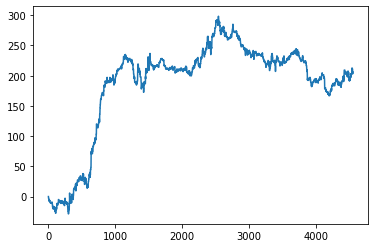

In [26]:
actions = np.where(sr > 0, 1, 0)
epi_rewards = rewards * actions
plt.plot(epi_rewards.cumsum())
epi_rewards.sum()

## distの最小値がthred以下の時

In [27]:
thred_list = []
mean_list = []
std_list = []
win_list = []
minv = risk_sensitive_q.min(axis=1)

for thred in np.arange(minv.min(), minv.max(), 0.1):
    actions = np.where(minv > thred, 1, 0)
    epi_rewards = (rewards * actions)
    mean = epi_rewards.mean()
    std = epi_rewards.std()
    win_list.append(sum(rewards * actions > 0) / sum(actions > 0))

    thred_list.append(thred)
    mean_list.append(mean)
    std_list.append(std)

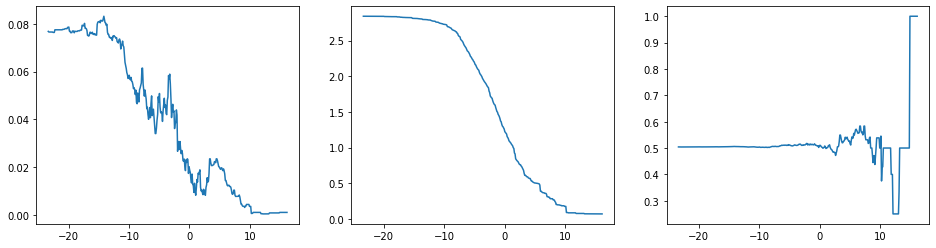

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].plot(thred_list, mean_list)
ax[1].plot(thred_list, std_list)
ax[2].plot(thred_list, win_list)

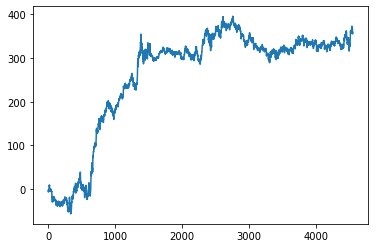

In [29]:
actions = np.where(minv > -20, 1, 0)
epi_rewards = rewards * actions
plt.plot(epi_rewards.cumsum())

# risk_averse

## mean

In [30]:
thred_list = []
mean_list = []
std_list = []
win_list = []
risk_averse_mean = np.mean(risk_averse_q, axis=1)

for thred in np.arange(risk_averse_mean.min(), risk_averse_mean.max(), 0.1):
    actions = np.where(risk_averse_mean > thred, 1, 0)
    epi_rewards = (rewards * actions)
    mean = epi_rewards.mean()
    std = epi_rewards.std()
    win_list.append(sum(rewards * actions > 0) / sum(actions > 0))

    thred_list.append(thred)
    mean_list.append(mean)
    std_list.append(std)

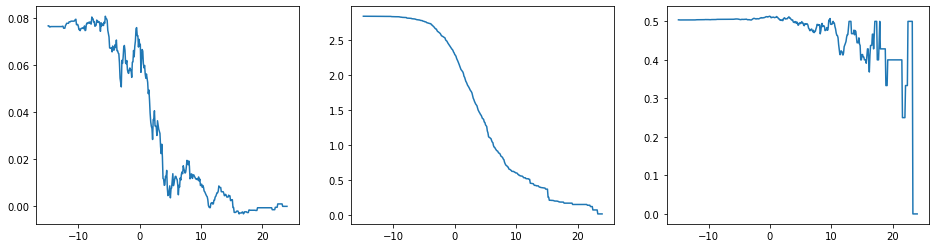

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].plot(thred_list, mean_list)
ax[1].plot(thred_list, std_list)
ax[2].plot(thred_list, win_list)

## Sharpe Ratio

In [32]:
thred_list = []
mean_list = []
std_list = []
win_list = []
sr = risk_averse_q.mean(axis=1) / risk_averse_q.std(axis=1)

for thred in np.arange(sr.min(), sr.max(), 0.1):
    actions = np.where(sr > thred, 1, 0)
    epi_rewards = (rewards * actions)
    mean = epi_rewards.mean()
    std = epi_rewards.std()
    win_list.append(sum(rewards * actions > 0) / sum(actions > 0))

    thred_list.append(thred)
    mean_list.append(mean)
    std_list.append(std)

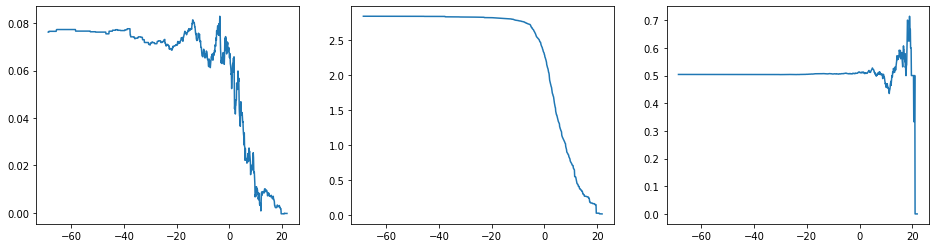

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].plot(thred_list, mean_list)
ax[1].plot(thred_list, std_list)
ax[2].plot(thred_list, win_list)

# プロット

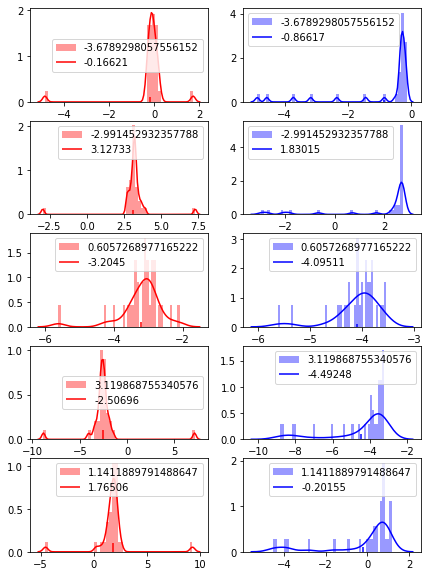

In [34]:
start = 0
N = 5
fig, ax = plt.subplots((N-start), 2, figsize=(7, (N-start)*2));

for i in range(start, N):    
    
    # 普通の分布
    sns.distplot(risk_neutral_q[i], bins=51, color='red', ax=ax[i - start][0], label=str(rewards[i]))
    mean = np.round(risk_neutral_q[i].mean(), 5)
    ax[i - start][0].vlines(mean, ymin=0, ymax=0.1, color='red', label=str(mean))

    # CVaR
    sns.distplot(risk_sensitive_q[i], bins=51, color='blue', ax=ax[i - start][1], label=str(rewards[i]))
    mean = np.round(risk_sensitive_q[i].mean(), 5)
    ax[i - start][1].vlines(mean, ymin=0, ymax=0.1, color='blue', label=str(mean))

    ax[i-start][0].legend()
    ax[i-start][1].legend()


In [35]:
for word in states[11]:
    print(TEXT.vocab.itos[word])

<cls>
決算
星取表
<company>
据え置き
●
ｻﾌﾟﾗｲｽﾞﾚｼｵ
n
0年0月期
<span>
<company>
0月期
連結
最終
益
0億
円
前年同期
0億
円
黒字
<span>
<company>
小高い
0月期
純利益
00
減
<eos>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>


In [36]:
# attn

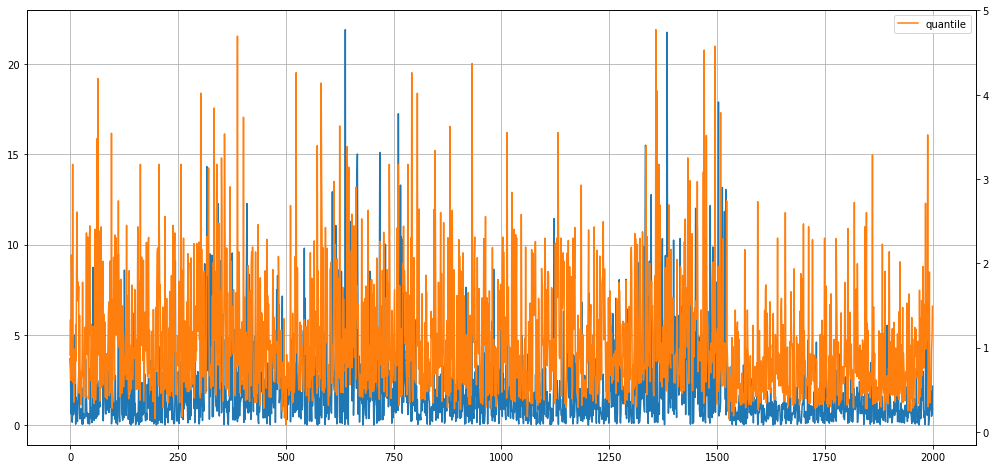

In [44]:
fig = plt.figure(figsize=(17, 8))
ax1 = fig.add_subplot(111)
ln1=ax1.plot(np.abs(rewards[:2000]), 'C0', label='reward')

ax2 = ax1.twinx()
std = np.abs(risk_neutral_q.std(axis=1))
ln2=ax2.plot(std[:2000], 'C1', label='quantile')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax1.grid(True)
plt.legend()

# マイナスリスク

In [38]:
risk_rewards = rewards.copy()
risk_rewards[risk_rewards > 0] = 0

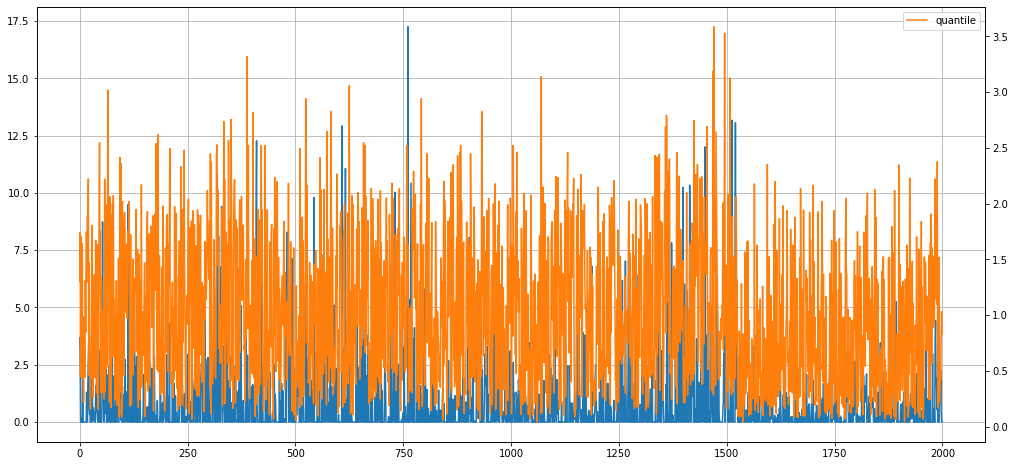

In [39]:
fig = plt.figure(figsize=(17, 8))
ax1 = fig.add_subplot(111)
ln1=ax1.plot(np.abs(risk_rewards[:2000]), 'C0', label='reward')

ax2 = ax1.twinx()
ln2=ax2.plot(np.abs(risk_sensitive_q.std(axis=1)[:2000]), 'C1', label='quantile')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax1.grid(True)
plt.legend()

In [40]:
return_rewards = rewards.copy()
return_rewards[return_rewards < 0] = 0

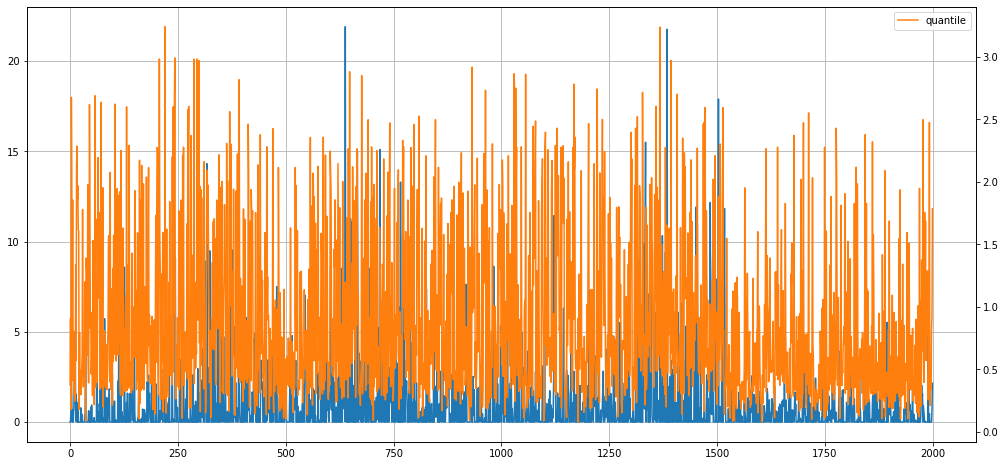

In [41]:
fig = plt.figure(figsize=(17, 8))
ax1 = fig.add_subplot(111)
ln1=ax1.plot(np.abs(return_rewards[:2000]), 'C0', label='reward')

ax2 = ax1.twinx()
ln2=ax2.plot(np.abs(risk_averse_q.std(axis=1)[:2000]), 'C1', label='quantile')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax1.grid(True)
plt.legend()

In [42]:
# HTMLを作成する関数を実装
def highlight(word, attn):
    "Attentionの値が大きいと文字の背景が濃い赤になるhtmlを出力させる関数"

    html_color = '#%02X%02X%02X' % (
        255, int(255*(1 - attn)), int(255*(1 - attn)))
    return '<span style="background-color: {}"> {}</span>'.format(html_color, word)


def mk_html(sentence, attens, reward, pred):

    # 表示用のHTMLを作成する
    html = '正解ラベル：{}<br>推論ラベル：{}<br><br>'.format(reward, pred)
#     html = ""
    # 1段目のAttention
    html += '[TransformerBlockの1段目のAttentionを可視化]<br>'
    for word, attn in zip(sentence, attens):
        html += highlight(TEXT.vocab.itos[word], attn)
    html += "<br><br>"

    return html

In [43]:
idx = 54
attn = attns[idx,:]
html_output = mk_html(states[idx], attn, rewards[idx], curr_q.mean(axis=1)[idx])
#                                            y[idx].item(),
#                                            pred[idx].item())
# 普通の分布
sns.distplot(curr_q[idx], bins=51, color='red', label=str(rewards[i]))
mean = np.round(curr_q[idx].mean(), 5)
plt.vlines(mean, ymin=0, ymax=0.2, color='red', label=str(mean))

HTML(html_output)

AttributeError: 'list' object has no attribute 'mean'

In [ ]:
mean = curr_q.mean(axis=1)
print(len(mean[mean > 0]), ' ', len(mean[mean < 0]))

In [ ]:
arr = curr_q.mean(axis=1)
print(arr.shape, arr[arr>0].shape, arr[arr<0].shape)